1 线性回归的从零开始

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数 $\mathbf{w} = [2, -3.4]^T$、$b = 4.2$ 和噪声项 $c$ 生成数据集及其标签：

$$\mathbf{y} = \mathbf{X}\mathbf{w} + b + c$$

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b +噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w))) #len(w) = len([2,-3.4]) = 2
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X,y.reshape((-1,1))

true_w = torch.tensor([2,-3.4]) # 这里定义了2个权重
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值(一个标量)

In [3]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([0.3939, 0.1644]) 
label: tensor([4.4335])


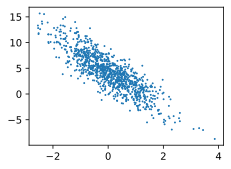

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1);

定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # 获取总样本数（1000个）
    indices = list(range(num_examples)) # 创建索引列表 [0,1,2,...,999]
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) # 打乱顺序，让训练更好
    for i in range(0, num_examples, batch_size): # 每次跳batch_size步
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.5008,  1.2476],
        [-1.0256,  0.1990],
        [-0.0960,  1.0759],
        [ 1.6727,  0.8413],
        [-0.0937, -1.0177],
        [ 0.0388,  0.5338],
        [-0.4416,  0.3274],
        [ 0.7630, -0.1986],
        [-1.0412, -0.5903],
        [-0.3410,  1.3166]]) 
 tensor([[ 0.9545],
        [ 1.4783],
        [ 0.3500],
        [ 4.6871],
        [ 7.4638],
        [ 2.4536],
        [ 2.1843],
        [ 6.4172],
        [ 4.1435],
        [-0.9524]])


定义初始化模型参数

In [6]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad= True)
b = torch.zeros(1,requires_grad=True)

定义模型

In [7]:
def linreg(X, w, b):
    """线性回归模型。"""
    #torch.matmul 是PyTorch中的矩阵乘法函数
    return torch.matmul(X,w) + b

定义损失函数

In [8]:
def squared_loss(y_hat, y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法 

In [9]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with torch.no_grad(): #更新的时候不要参与梯度计算
        for param in params:
            # 手动更新参数
            # w -= lr * w.grad / batch_size
            # b -= lr * b.grad / batch_size
            param -= lr * param.grad / batch_size
            param.grad.zero_() #把梯度设为0，这样下一次计算梯度的时候就不会和上一次相关了

训练过程

In [10]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size, 1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w, b]的梯度
        l.sum().backward() #l.sum()：把批次内所有样本的损失加起来; .backward()：自动求导，计算梯度
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.046257
epoch 2, loss 0.000209
epoch 3, loss 0.000051


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [11]:
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差:tensor([-0.0003, -0.0013], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0009], grad_fn=<RsubBackward1>)
